In [2]:
import pandas as pd


df = pd.read_csv(r'G:\Topic Modeling Project\artifacts\bbc-news-data.csv', sep='\t')
display(df)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [3]:
import re
import nltk
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

# ---------------------------------------
# 🧠 TEXT PREPROCESSING PIPELINE
# ---------------------------------------

class TextPreprocessor:
    def __init__(self, column='content', freq_top_n=100, tfidf_low_n=100, doc_freq_thresh=0.6):
        """
        Initialize preprocessing configuration.
        :param column: column name containing raw text
        :param freq_top_n: top N most frequent words to consider as potential stopwords
        :param tfidf_low_n: bottom N words by mean TF-IDF to consider as potential stopwords
        :param doc_freq_thresh: threshold (fraction of docs) for high document frequency words
        """
        self.column = column
        self.freq_top_n = freq_top_n
        self.tfidf_low_n = tfidf_low_n
        self.doc_freq_thresh = doc_freq_thresh
        self.final_stopwords = None

        nltk.download('stopwords', quiet=True)
        self.default_stopwords = set(stopwords.words('english'))

    # ------------------------------
    # 1️⃣ Build custom stopword list
    # ------------------------------
    def build_custom_stopwords(self, df):
        """
        Automatically identify corpus-specific stopwords.
        """

        # Word frequency
        all_text = ' '.join(df[self.column]).lower()
        words = re.findall(r'\b\w+\b', all_text)
        word_counts = Counter(words)
        freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

        # Document frequency
        cv = CountVectorizer()
        X = cv.fit_transform(df[self.column])
        doc_freq = (X > 0).sum(axis=0)
        doc_freq_df = pd.DataFrame({
            'word': cv.get_feature_names_out(),
            'doc_count': np.asarray(doc_freq).ravel()
        })

        # TF-IDF
        tfidf = TfidfVectorizer()
        X_tfidf = tfidf.fit_transform(df[self.column])
        mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
        tfidf_df = pd.DataFrame({
            'word': tfidf.get_feature_names_out(),
            'mean_tfidf': mean_tfidf
        })

        # Combine potential stopwords
        top_freq_words = freq_df.sort_values('count', ascending=False).head(self.freq_top_n)['word'].tolist()
        high_doc_words = doc_freq_df[
            doc_freq_df['doc_count'] > self.doc_freq_thresh * len(df)
        ]['word'].tolist()
        low_tfidf_words = tfidf_df.sort_values('mean_tfidf', ascending=True).head(self.tfidf_low_n)['word'].tolist()

        custom_stopwords = set(top_freq_words + high_doc_words + low_tfidf_words) - self.default_stopwords
        self.final_stopwords = self.default_stopwords.union(custom_stopwords)

        print(f"✅ Custom stopwords identified: {len(custom_stopwords)} new words added.")
        print(f"🔹 Total stopwords: {len(self.final_stopwords)}")

        return self.final_stopwords

    # ------------------------------
    # 2️⃣ Clean text
    # ------------------------------
    def clean_text(self, text):
        """
        Clean and normalize text using the final stopword list.
        """
        text = text.lower()
        text = re.sub(r'[^a-z\s]', ' ', text)
        tokens = text.split()
        if self.final_stopwords:
            tokens = [t for t in tokens if t not in self.final_stopwords and len(t) > 2]
        return ' '.join(tokens)

    # ------------------------------
    # 3️⃣ Full preprocessing pipeline
    # ------------------------------
    def preprocess(self, df):
        """
        Run full preprocessing pipeline:
        1. Build custom stopwords
        2. Clean each text entry
        """
        print("🔍 Building custom stopword list...")
        self.build_custom_stopwords(df)

        print("🧹 Cleaning text data...")
        df[f'{self.column}_clean'] = df[self.column].apply(self.clean_text)

        print("✅ Text preprocessing completed.")
        return df


In [4]:


# Initialize preprocessor
tp=TextPreprocessor(column='content')

# Run the preprocessing pipeline
clean_df = tp.preprocess(df)

# See result
print(clean_df[['content', 'content_clean']].head())

# Now you can use clean_df['content_clean'] for topic modeling (LDA, NMF, etc.)


🔍 Building custom stopword list...
✅ Custom stopwords identified: 130 new words added.
🔹 Total stopwords: 328
🧹 Cleaning text data...
✅ Text preprocessing completed.
                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                       content_clean  
0  quarterly profits media giant timewarner jumpe...  
1  dollar hit highest level euro almost months fe...  
2  owners embattled russian oil giant yukos ask b...  
3  british airways blamed high fuel prices drop p...  
4  shares drinks food firm allied domecq risen sp...  


In [5]:
print(tp.final_stopwords)

{'been', 'him', "he'll", "we've", "you've", 'have', 'lp', 'having', 'if', 'itself', 'those', 'himself', 'had', "i'm", 'above', 'out', 'haven', 'won', 'them', 'down', "she's", 'their', 'yours', 'last', 'years', 'precautions', 'only', 'during', 'neutered', 'time', "it'll", 'just', 'all', 'duetted', 'forgets', 'like', 'me', "they're", 'her', 'will', 'too', 'interned', 'more', 'for', 'instituted', 'isn', 'll', 'duped', 'hasn', 'own', 'then', 'how', 'first', 'movers', 'insidiously', "doesn't", 'embarassment', 'nuked', 'is', 't', 'now', "it's", 'perpetuation', 'paranoia', 'weren', 'verbalise', 'shatter', 'two', 'each', 'm', 'myself', 'denunciations', 'government', 'he', 'mightn', 'buzzcocks', 'they', 'hadn', 'are', 's', 'until', 'redifining', 'game', 'both', 'gagged', 'ain', 'could', 'o', 'back', 'once', 'people', 'roughshod', 'josef', 'through', 'these', '1', 'so', 'has', 'wouldn', 'should', 'and', 'be', 'shan', 'same', 'at', 'us', 'blockade', 'siblings', "shouldn't", "that'll", 'y', 'your'

In [6]:
import gensim
from gensim import corpora
import spacy

# Load spacy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Tokenize + Lemmatize
def preprocess_for_lda(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_ for token in doc 
                  if token.is_alpha and not token.is_stop and len(token) > 2]
        processed_texts.append(tokens)
    return processed_texts

texts = preprocess_for_lda(clean_df['content_clean'])
print("✅ Example processed text:", texts[0][:15])

✅ Example processed text: ['quarterly', 'profit', 'media', 'giant', 'timewarner', 'jump', 'month', 'december', 'early', 'firm', 'big', 'investor', 'google', 'benefit', 'sale']


In [8]:
# Create dictionary
id2word = corpora.Dictionary(texts)

# Filter extremes to remove too rare/common words
id2word.filter_extremes(no_below=5, no_above=0.5)

# Create the bag-of-words corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
from gensim.models.ldamodel import LdaModel


num_topics = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [14]:
from gensim.models import CoherenceModel

# Coherence 'c_v' measures semantic similarity between top words in topics
coherence_model_lda = CoherenceModel(
    model=lda_model,     # your trained LDA model
    texts=texts,         # tokenized & lemmatized texts
    dictionary=id2word,  # gensim dictionary
    coherence='c_v'      # most commonly used
)

coherence_score = coherence_model_lda.get_coherence()
print(f"✅ LDA Coherence Score: {coherence_score:.4f}")

✅ LDA Coherence Score: 0.5983


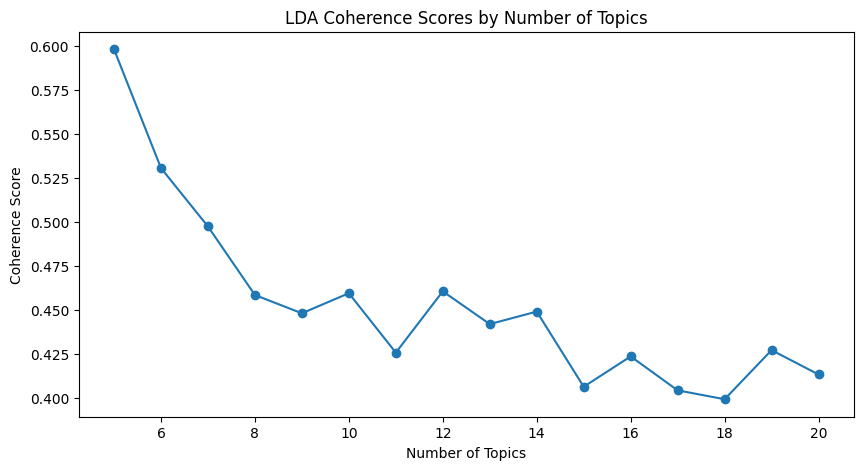

✅ Optimal number of topics: 5, Coherence: 0.5983


In [15]:
coherence_values = []
model_list = []
topic_range = range(5, 21, 1)  # test topics from 5 to 20

for num_topics in topic_range:
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=42,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plot coherence vs number of topics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Coherence Scores by Number of Topics")
plt.show()

# Best number of topics
best_index = coherence_values.index(max(coherence_values))
print(f"✅ Optimal number of topics: {topic_range[best_index]}, Coherence: {coherence_values[best_index]:.4f}")


In [16]:
from gensim.models.ldamodel import LdaModel

num_topics = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

lda_model.print_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.012*"technology" + 0.011*"digital" + 0.008*"consumer" + 0.008*"net" + 0.008*"million" + 0.008*"site" + 0.008*"market" + 0.008*"service" + 0.008*"high" + 0.007*"broadband"'),
 (1,
  '0.027*"play" + 0.022*"player" + 0.021*"game" + 0.012*"win" + 0.007*"go" + 0.007*"team" + 0.006*"think" + 0.006*"title" + 0.006*"get" + 0.006*"old"'),
 (2,
  '0.015*"mobile" + 0.012*"phone" + 0.009*"user" + 0.009*"use" + 0.008*"computer" + 0.007*"music" + 0.007*"software" + 0.007*"system" + 0.006*"network" + 0.006*"service"'),
 (3,
  '0.014*"england" + 0.011*"second" + 0.010*"set" + 0.010*"half" + 0.009*"final" + 0.008*"ireland" + 0.008*"minute" + 0.007*"try" + 0.007*"coach" + 0.007*"injury"'),
 (4,
  '0.022*"club" + 0.013*"chelsea" + 0.010*"united" + 0.010*"arsenal" + 0.008*"deal" + 0.008*"boss" + 0.007*"football" + 0.007*"premiership" + 0.007*"manager" + 0.006*"russian"')]

In [17]:
from gensim.models import CoherenceModel

# Coherence 'c_v' measures semantic similarity between top words in topics
coherence_model_lda = CoherenceModel(
    model=lda_model,     # your trained LDA model
    texts=texts,         # tokenized & lemmatized texts
    dictionary=id2word,  # gensim dictionary
    coherence='c_v'      # most commonly used
)

coherence_score = coherence_model_lda.get_coherence()
print(f"✅ LDA Coherence Score: {coherence_score:.4f}")

✅ LDA Coherence Score: 0.5983


In [18]:
# Calculate and print the perplexity score of the LDA model
perplexity = lda_model.log_perplexity(corpus)
print(f"✅ LDA Model Perplexity: {perplexity:.4f}")


✅ LDA Model Perplexity: -7.9169


Num Topics: 2, Perplexity: -7.9706
Num Topics: 3, Perplexity: -7.9009
Num Topics: 4, Perplexity: -7.8930
Num Topics: 5, Perplexity: -7.9169
Num Topics: 6, Perplexity: -7.9325
Num Topics: 7, Perplexity: -7.9254
Num Topics: 8, Perplexity: -7.9487
Num Topics: 9, Perplexity: -7.9742
Num Topics: 10, Perplexity: -7.9604


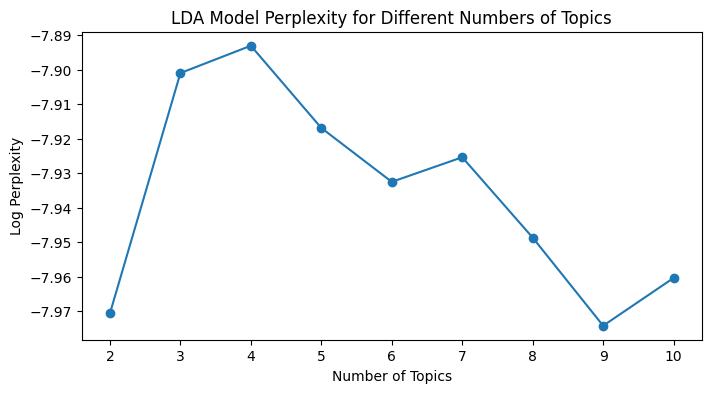

In [20]:
# Evaluate perplexity score for different number of topics
from gensim.models.ldamodel import LdaModel

topic_range = range(2, 11)  # Try 2 through 10 topics
perplexities = []

for n_topics in topic_range:
    lda = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=n_topics,
        random_state=42,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    perp = lda.log_perplexity(corpus)
    perplexities.append(perp)
    print(f'Num Topics: {n_topics}, Perplexity: {perp:.4f}')

# Optional: Plotting perplexity scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(list(topic_range), perplexities, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log Perplexity')
plt.title('LDA Model Perplexity for Different Numbers of Topics')
plt.show()


Num Topics: 2, NMF Reconstruction Error: 46.3026
Num Topics: 3, NMF Reconstruction Error: 46.0992
Num Topics: 4, NMF Reconstruction Error: 45.9241
Num Topics: 5, NMF Reconstruction Error: 45.7600
Num Topics: 6, NMF Reconstruction Error: 45.6486
Num Topics: 7, NMF Reconstruction Error: 45.5466
Num Topics: 8, NMF Reconstruction Error: 45.4483
Num Topics: 9, NMF Reconstruction Error: 45.3470
Num Topics: 10, NMF Reconstruction Error: 45.2576


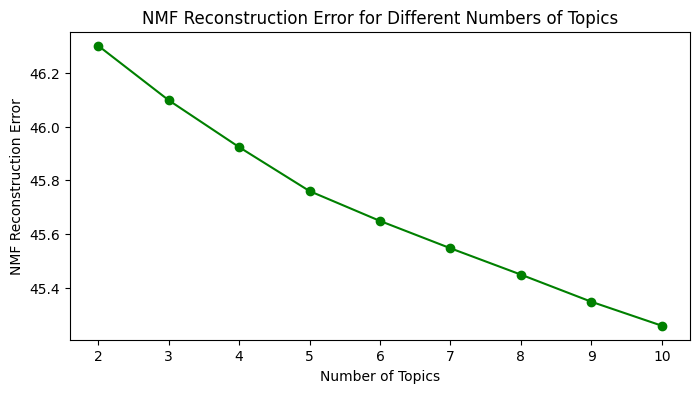

In [21]:

# NMF (Non-Negative Matrix Factorization) topic modeling and evaluation across topic numbers
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Prepare documents as plain text
documents = [doc for doc in df['content']]

# TF-IDF vectorization (NMF generally works well with TF-IDF)
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english'
)
tfidf = tfidf_vectorizer.fit_transform(documents)

topic_range = range(2, 11)  # 2 to 10 topics
nmf_reconstruction_errors = []

for n_topics in topic_range:
    nmf_model = NMF(
        n_components=n_topics,
        random_state=42,
        max_iter=200,
        init='nndsvda',
        solver='cd'
    )
    W = nmf_model.fit_transform(tfidf)
    H = nmf_model.components_
    # The lower the reconstruction error, the better
    recon_error = nmf_model.reconstruction_err_
    nmf_reconstruction_errors.append(recon_error)
    print(f'Num Topics: {n_topics}, NMF Reconstruction Error: {recon_error:.4f}')

# Plot NMF reconstruction error for different number of topics
plt.figure(figsize=(8,4))
plt.plot(list(topic_range), nmf_reconstruction_errors, marker='o', color='green')
plt.xlabel('Number of Topics')
plt.ylabel('NMF Reconstruction Error')
plt.title('NMF Reconstruction Error for Different Numbers of Topics')
plt.show()



Num Topics: 2, NMF Coherence Score (c_v): 0.5205
Num Topics: 3, NMF Coherence Score (c_v): 0.5631
Num Topics: 4, NMF Coherence Score (c_v): 0.6719
Num Topics: 5, NMF Coherence Score (c_v): 0.7142
Num Topics: 6, NMF Coherence Score (c_v): 0.7534
Num Topics: 7, NMF Coherence Score (c_v): 0.7329
Num Topics: 8, NMF Coherence Score (c_v): 0.7587
Num Topics: 9, NMF Coherence Score (c_v): 0.7498
Num Topics: 10, NMF Coherence Score (c_v): 0.7596


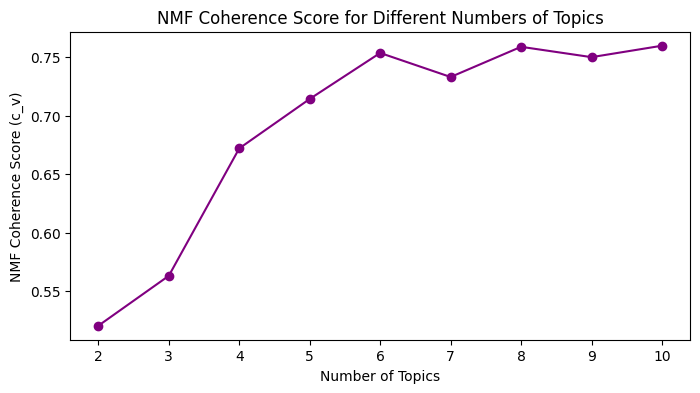

In [22]:
# Calculate coherence values for NMF model for different number of topics
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Prepare texts for Gensim (tokenized and preprocessed)
texts = [doc.split() for doc in df['content'].apply(lambda x: x.lower())]

# Build the Dictionary and Corpus
gensim_dictionary = Dictionary(texts)
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

nmf_coherence_values = []

for n_topics in topic_range:
    nmf_model = NMF(
        n_components=n_topics,
        random_state=42,
        max_iter=200,
        init='nndsvda',
        solver='cd'
    )
    W = nmf_model.fit_transform(tfidf)
    H = nmf_model.components_
    # Get the top words for each topic
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    topics = []
    for topic_weights in H:
        top_word_indices = topic_weights.argsort()[:-11:-1]
        topics.append([tfidf_feature_names[i] for i in top_word_indices])
    # Calculate coherence score using c_v
    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=gensim_dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    nmf_coherence_values.append(coherence_score)
    print(f'Num Topics: {n_topics}, NMF Coherence Score (c_v): {coherence_score:.4f}')

# Plot NMF coherence scores for different number of topics
plt.figure(figsize=(8,4))
plt.plot(list(topic_range), nmf_coherence_values, marker='o', color='purple')
plt.xlabel('Number of Topics')
plt.ylabel('NMF Coherence Score (c_v)')
plt.title('NMF Coherence Score for Different Numbers of Topics')
plt.show()

# --- Perplexity is not well-defined for NMF (as it is for probabilistic models like LDA) ---
# If you want to estimate something similar, you may use the exponential of the reconstruction error normalized by number of words.
# But this is not comparable to LDA's perplexity.
